# Exercise 8

## Introduction to the algorithms

1. ### Greedy Search  
•	**Representation**: Use the number of boxes not on storage locations as the heuristic.  
•	**Evaluation**: Fast but might not always find the shortest path due to its focus on immediate cost minimization.  
2. ### A* Search  
•	**Representation**: Combine the distance of boxes from their nearest storage locations and the distance of the player to the nearest box not in a storage location as the heuristic.  
•	**Evaluation**: Likely to be effective in finding an optimal solution due to its balance of cost and heuristic, but potentially slow on complex boards.  
3. ### Breadth-First Search (BFS)  
•	**Representation**: Explore all possible movements level by level, without considering the distance to the goal.  
•	**Evaluation**: Guaranteed to find the shortest path in terms of the number of moves, but can be very memory-intensive.  
4. ### Uniform Cost Search  
•	**Representation**: Treats each move as a uniform cost. Similar to BFS but prioritizes paths with the lowest total cost.  
•	**Evaluation**: Effective for finding the least costly path if all moves are equal, but may not be efficient for Sokoban where strategic planning is key.  
5. ### Depth-First Search (DFS)  
•	**Representation**: Explore as far as possible along each branch before backtracking.  
•	**Evaluation**: Not ideal for Sokoban due to the risk of getting stuck in loops or taking inefficient paths.  
6. ### Depth-Limited Search  
•	**Representation**: Similar to DFS but with a limit on the depth to prevent infinite looping.  
•	**Evaluation**: Can mitigate some of DFS's issues but might not find a solution if the limit is too low.  
7. ### Iterative Deepening Depth-First Search (IDDFS)  
•	**Representation**: Combines the depth-first search's space efficiency and the breadth-first search's completeness (by progressively deepening the search depth).  
•	**Evaluation**: More suitable for Sokoban than standard DFS, as it finds the shallowest solution, but can be less efficient than other methods.  

## Overall Class

In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

class SokobanEnv:
    def __init__(self, level):
        self.level = np.array(level)
        self.agent_pos = self.find_position(4)  # 4 represents the agent
        self.boxes = self.find_positions(2)     # 2 represents boxes
        self.walls = self.find_positions(1)     # 1 represents walls
        self.goals = self.find_positions(3)     # 3 represents goals

    def find_position(self, tile_type):
        '''Finds the first occurrence of a given tile type.'''
        pos = np.argwhere(self.level == tile_type)
        return tuple(pos[0]) if len(pos) > 0 else None

    def find_positions(self, tile_type):
        '''Finds and returns positions of a specific tile type as a frozenset.'''
        return frozenset(map(tuple, np.argwhere(self.level == tile_type)))

    def print_level(self):
        '''Prints a textual representation of the level.'''
        symbols = {0: '.', 1: '#', 2: '$', 3: '*', 4: '@', 5: '+'}
        print_level = np.vectorize(symbols.get)(self.level)
        print('\n'.join([''.join(row) for row in print_level]))

    def show_level(self):
        '''Displays the level using images for each type of tile, ensuring they fit and are centered, with visible grid lines.'''
        fig, ax = plt.subplots(figsize=(5, 6))  # Adjust figure size to match your grid
        ax.set_aspect('equal')
        
        # Load images
        wall_img = mpimg.imread('images/wall.webp')
        box_img = mpimg.imread('images/box.webp')
        goal_img = mpimg.imread('images/goal.webp')
        agent_img = mpimg.imread('images/agent.webp')
        floor_img = mpimg.imread('images/floor.webp')

        # Calculate zoom based on the axes size and image pixel dimensions
        num_rows, num_cols = self.level.shape
        zoom_level = fig.get_size_inches()[0] * fig.dpi / (num_cols * max(wall_img.shape[0], wall_img.shape[1]))

        # Loop through the grid and place images, ensuring they are centered and fit the grid cells
        for (i, j), value in np.ndenumerate(self.level):
            if value == 1:  # Wall
                image = wall_img
            elif value == 2:  # Box
                image = box_img
            elif value == 3:  # Goal
                image = goal_img
            elif value == 4:  # Agent
                image = agent_img
            else:  # Floor or undefined
                image = floor_img
            
            # Create an image box with adjusted zoom
            im = OffsetImage(image, zoom=zoom_level)
            ab = AnnotationBbox(im, (j, i), frameon=False, box_alignment=(0.5, 0.5))
            ax.add_artist(ab)

        # Set the grid lines and ticks
        ax.set_xlim(-0.5, num_cols - 0.5)
        ax.set_ylim(num_rows - 0.5, -0.5)  # Y-axis inverted for matrix-like representation
        ax.set_xticks(np.arange(-0.5, num_cols, 1))
        ax.set_yticks(np.arange(-0.5, num_rows, 1))
        ax.grid(which='major', color='k', linestyle='-', linewidth=2)
        plt.axis('off')
        plt.show()
        
def is_goal(state, env):
    _, box_positions = state
    return box_positions <= env.goals  # All boxes on goal positions

def reconstruct_path(came_from, start, goal):
    '''Reconstructs the path from start to goal based on came_from data.'''
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path

def get_successors(state, env):
    agent_pos, boxes = state
    successors = []

    # Directions the agent can move: up, down, left, right
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    for d in directions:
        new_agent_pos = (agent_pos[0] + d[0], agent_pos[1] + d[1])

        # Skip if the new agent position is a wall
        if new_agent_pos in env.walls:
            continue

        # If the new agent position has a box and the box can be pushed
        if new_agent_pos in boxes:
            new_box_pos = (new_agent_pos[0] + d[0], new_agent_pos[1] + d[1])

            # Check if the new box position is valid (not a wall or another box)
            if new_box_pos not in env.walls and new_box_pos not in boxes:
                # Create a new state with the box moved
                new_boxes = set(boxes)
                new_boxes.remove(new_agent_pos)
                new_boxes.add(new_box_pos)

                # Add the new state to the successors list
                successors.append((new_agent_pos, frozenset(new_boxes)))
        else:
            # If the new agent position doesn't have a box, just move the agent
            successors.append((new_agent_pos, boxes))

    return successors

def translate_to_moves(path, env):
    moves = []
    for i in range(1, len(path)):
        previous_state, current_state = path[i - 1], path[i]
        prev_agent_pos, current_agent_pos = previous_state[0], current_state[0]
        
        # Determine the direction of the move
        dy, dx = current_agent_pos[0] - prev_agent_pos[0], current_agent_pos[1] - prev_agent_pos[1]
        if dy == -1:
            move = 'up'
        elif dy == 1:
            move = 'down'
        elif dx == -1:
            move = 'left'
        elif dx == 1:
            move = 'right'
        
        # Check if it was a push move
        prev_boxes, current_boxes = previous_state[1], current_state[1]
        if prev_boxes != current_boxes:  # Means a box was pushed
            move = 'push ' + move
        
        moves.append(move)
    
    return moves

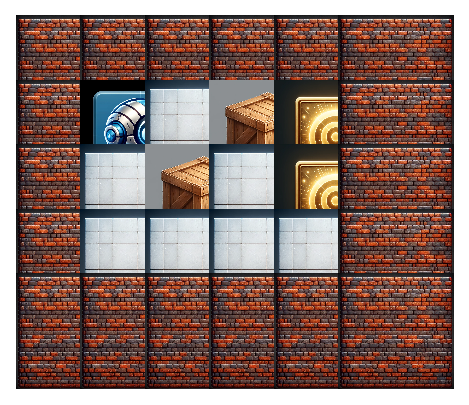

In [22]:
# Initialize your Sokoban environment with a test level
level = [
    [1, 1, 1, 1, 1, 1],
    [1, 4, 0, 2, 3, 1],
    [1, 0, 2, 0, 3, 1],
    [1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1]
]

env = SokobanEnv(level)
env.show_level()  # Optional: to visually check the level

# Define the start state for BFS
initial_state = (env.agent_pos, env.boxes)


## Greedy Search

In [25]:
import heapq

def greedy_best_first_search(start, is_goal, get_successors, heuristic):
    # Use a priority queue to store the states with the priority being the heuristic
    start_time = time.time()
    frontier = [(heuristic(start), start)]
    heapq.heapify(frontier)
    explored = set()
    came_from = {start: None}
    nodes_expanded = 0  # Counter for expanded nodes

    while frontier:
        _, current_state = heapq.heappop(frontier)
        nodes_expanded += 1  # Increment for each node expanded
        
        if is_goal(current_state):
            end_time = time.time()
            print(f"Greedy Best-First Search took {end_time - start_time:.5f} seconds.")
            return reconstruct_path(came_from, start, current_state), nodes_expanded
        
        explored.add(current_state)
        
        for next_state in get_successors(current_state):
            if next_state not in explored:
                heapq.heappush(frontier, (heuristic(next_state), next_state))
                came_from[next_state] = current_state
    
    end_time = time.time()
    print(f"Greedy Best-First Search took {end_time - start_time:.5f} seconds but found no solutions.")
    return None, nodes_expanded

# Define a heuristic function for Sokoban
def sokoban_heuristic(state):
    # This example uses a simple heuristic:
    # The sum of the Manhattan distances from each box to the nearest goal
    _, boxes = state
    total_distance = 0
    for box in boxes:
        distance = min(abs(box[0] - goal[0]) + abs(box[1] - goal[1]) for goal in env.goals)
        total_distance += distance
    return total_distance

# Define the start state for Greedy Best-First Search using the attributes from the SokobanEnv instance
initial_state = (env.agent_pos, env.boxes)

# Now, run Greedy Best-First Search, using the is_goal, get_successors functions, and heuristic
gbfs_solution, nodes_greedy = greedy_best_first_search(
    initial_state,
    lambda state: is_goal(state, env),
    lambda state: get_successors(state, env),
    sokoban_heuristic
)

# Check if a solution was found
if gbfs_solution:
    print("A solution has been found using Greedy Search!")
    moves = translate_to_moves(gbfs_solution, env)  # Assuming you've defined this function as in BFS/UCS
    for move in moves:
        print(move)
else:
    print("No solution exists for this level using Greedy Search.")


Greedy Best-First Search took 0.00141 seconds.
A solution has been found using Greedy Search!
right
push right
left
left
down
push right
push right


## A* Search

In [26]:
import heapq

def astar_search(start, is_goal, get_successors, heuristic):
    start_time = time.time()
    frontier = [(heuristic(start), start)]  # Priority queue, with heuristic as priority
    heapq.heapify(frontier)
    came_from = {start: None}
    cost_so_far = {start: 0}  # This is the cost from the start node to the current node, g(n)
    nodes_expanded = 0

    while frontier:
        _, current_state = heapq.heappop(frontier)
        nodes_expanded += 1
        
        if is_goal(current_state):
            end_time = time.time()
            print(f"A* Search took {end_time - start_time:.5f} seconds.")
            return reconstruct_path(came_from, start, current_state), nodes_expanded
        
        for next_state in get_successors(current_state):
            new_cost = cost_so_far[current_state] + 1  # Assuming each step costs 1
            if next_state not in cost_so_far or new_cost < cost_so_far[next_state]:
                cost_so_far[next_state] = new_cost
                priority = new_cost + heuristic(next_state)  # f(n) = g(n) + h(n)
                heapq.heappush(frontier, (priority, next_state))
                came_from[next_state] = current_state
                
    end_time = time.time()  
    print(f"A* Search took {end_time - start_time:.4f} seconds but found no solution.")
    return None, nodes_expanded

# Define the heuristic function for Sokoban
def sokoban_heuristic(state):
    # This is the h(n) part of f(n) = g(n) + h(n) and can be the same heuristic as in greedy_best_first_search
    _, boxes = state
    total_distance = 0
    for box in boxes:
        distance = min(abs(box[0] - goal[0]) + abs(box[1] - goal[1]) for goal in env.goals)
        total_distance += distance
    return total_distance

# You can use the same is_goal and get_successors functions defined earlier for BFS/UCS/DFS.

# Define the start state for A* Search using the attributes from the SokobanEnv instance
initial_state = (env.agent_pos, env.boxes)

# Now, run A* Search, using the is_goal, get_successors functions, and heuristic
astar_solution, nodes_astar = astar_search(
    initial_state,
    lambda state: is_goal(state, env),
    lambda state: get_successors(state, env),
    sokoban_heuristic
)

# Check if a solution was found
if astar_solution:
    moves = translate_to_moves(astar_solution, env)  # This function will need to be implemented as in BFS/UCS
    for move in moves:
        print(move)
else:
    print("No solution exists for this level using A* Search.")



A* Search took 0.00025 seconds.
down
push right
push right
left
up
push right


## Breadth First Search

In [27]:
from collections import deque

def bfs(start, is_goal, get_successors):
    '''Performs BFS to find a path from the start state to a goal state.'''
    start_time = time.time()
    frontier = deque([start])  # States to explore
    visited = set()  # Visited states
    came_from = {start: None}  # To reconstruct the path
    nodes_expanded = 0

    while frontier:
        current_state = frontier.popleft()
        nodes_expanded += 1
        
        if is_goal(current_state):
            end_time = time.time()
            print(f"BFS took {end_time - start_time:.5f} seconds to find a solution.")
            return reconstruct_path(came_from, start, current_state), nodes_expanded
        
        visited.add(current_state)
        
        for next_state in get_successors(current_state):
            if next_state not in visited and next_state not in frontier:
                frontier.append(next_state)
                came_from[next_state] = current_state
    end_time = time.time()
    print(f"BFS took {end_time - start_time:.5f} seconds but found no solutions.")
    return None, nodes_expanded  # No path found

# Now, run BFS, using the is_goal and get_successors functions you will define
solution, nodes_bfs = bfs(initial_state, lambda state: is_goal(state, env), lambda state: get_successors(state, env))

# Assuming `solution` is the output from the BFS
if solution:
    moves = translate_to_moves(solution, env)
    for move in moves:
        print(move)
else:
    print("No solution exists for this level.")

BFS took 0.00054 seconds to find a solution.
down
push right
push right
left
up
push right


## Uniform Cost Search

In [28]:
import heapq

def uniform_cost_search(start, is_goal, get_successors, cost_fn):
    start_time = time.time()
    frontier = [(0, start)]  # Priority queue
    heapq.heapify(frontier)
    explored = set()
    came_from = {start: None}
    cost_so_far = {start: 0}
    nodes_expanded = 0

    while frontier:
        current_cost, current_state = heapq.heappop(frontier)
        nodes_expanded += 1
        
        if is_goal(current_state):
            end_time = time.time()
            print(f"UCS took {end_time - start_time:.5f} seconds to find a solution.")
            return reconstruct_path(came_from, start, current_state), nodes_expanded
        
        explored.add(current_state)
        
        for next_state in get_successors(current_state):
            new_cost = current_cost + cost_fn(current_state, next_state)
            if next_state not in explored or new_cost < cost_so_far.get(next_state, float('inf')):
                cost_so_far[next_state] = new_cost
                priority = new_cost
                heapq.heappush(frontier, (priority, next_state))
                came_from[next_state] = current_state
    end_time = time.time()
    print(f"UCS took {end_time - start_time: .5f} seconds but found no solutions.")
    
    return None, nodes_expanded

def cost_fn(current_state, next_state):
    # Moves have a cost of 1, pushing a box has a cost of 2
    current_agent_pos, current_boxes = current_state
    next_agent_pos, next_boxes = next_state

    if current_agent_pos in current_boxes and current_agent_pos != next_agent_pos:
        return 2  # Higher cost for pushing a box
    else:
        return 1  # Normal cost for a move

# Initial state, is_goal, and get_successors remain unchanged from your BFS setup

# Run the uniform-cost search algorithm
ucs_solution, nodes_ucs = uniform_cost_search(
    initial_state,
    lambda state: is_goal(state, env),
    lambda state: get_successors(state, env),
    cost_fn
)

# Check if a solution was found
if ucs_solution:
    print("A solution has been found using UCS!")
    # The same translate_to_moves function from BFS can be used
    moves = translate_to_moves(ucs_solution, env)
    for move in moves:
        print(move)
else:
    print("No solution exists for this level using UCS.")


UCS took 0.00050 seconds to find a solution.
A solution has been found using UCS!
down
push right
push right
left
up
push right


## Depth First Search

In [29]:
def depth_first_search(start, is_goal, get_successors):
    start_time = time.time()
    frontier = [start]  # Stack for DFS
    explored = set()
    came_from = {start: None}
    nodes_expanded = 0

    while frontier:
        current_state = frontier.pop()  # Pop from stack, LIFO
        nodes_expanded += 1  # Increment the counter when expanding the node
        
        if is_goal(current_state):
            end_time = time.time()
            print(f"DFS took {end_time - start_time:.5f} seconds to find a solution.")
            return reconstruct_path(came_from, start, current_state), nodes_expanded
        
        explored.add(current_state)
        
        for next_state in get_successors(current_state):
            if next_state not in explored and next_state not in frontier:
                frontier.append(next_state)
                came_from[next_state] = current_state
    end_time = time.time()
    print(f"DFS took {end_time - start_time:.5f} seconds but found no solutions.")
    return None, nodes_expanded

In [30]:
# Assuming is_goal and get_successors are already defined and imported into your notebook

# Define the start state for DFS using the attributes from the SokobanEnv instance
initial_state = (env.agent_pos, env.boxes)

# Now, run DFS, using the is_goal and get_successors functions you've defined
dfs_solution, nodes_dfs = depth_first_search(initial_state, lambda state: is_goal(state, env), lambda state: get_successors(state, env))

# Check if a solution was found
if dfs_solution:
    print("A solution has been found using DFS!")
    moves = translate_to_moves(dfs_solution, env)
    for move in moves:
        print(move)
else:
    print("No solution exists for this level using DFS.")


DFS took 0.00006 seconds to find a solution.
A solution has been found using DFS!
right
push right
left
left
down
push right
push right


## Depth Limited Search

In [31]:
def depth_limited_search(start, is_goal_fn, get_successors_fn, limit):
    start_time = time.time()
    nodes_expanded = 0

    def recursive_dls(node, depth):
        nonlocal nodes_expanded  # Allow the function to modify the outer variable
        nodes_expanded += 1  # Increment nodes expanded counter

        if is_goal_fn(node):
            return [node], nodes_expanded  # Return path and count
        if depth == 0:
            return 'cutoff', nodes_expanded  # Return cutoff indication and count
        else:
            cutoff_occurred = False
            for child in get_successors_fn(node):
                if child not in explored:
                    explored.add(child)
                    result, count = recursive_dls(child, depth - 1)  # Get result and count from deeper level
                    if result == 'cutoff':
                        cutoff_occurred = True
                    elif result is not None:
                        result.insert(0, node)
                        return result, nodes_expanded  # Return path and count
            return ('cutoff' if cutoff_occurred else None), nodes_expanded
    
    explored = set()
    result, nodes_expanded = recursive_dls(start, limit)

    end_time = time.time()
    if result == 'cutoff':
        print(f"DLS reached cutoff within the depth limit of {limit}, taking {end_time - start_time:.5f} seconds.")
    elif result is not None:
        print(f"DLS found a solution within the depth limit of {limit}, taking {end_time - start_time:.5f} seconds.")
    else:
        print(f"DLS found no solutions and no cutoff occurred within the depth limit of {limit}, taking {end_time - start_time:.5f} seconds.")
        
    return result, nodes_expanded  # Return the result and the count of nodes expanded

In [32]:
# Define the start state for DLS using the attributes from the SokobanEnv instance
initial_state = (env.agent_pos, env.boxes)

# Define a limit for the depth
depth_limit = 10  # You can set this to the appropriate depth limit for your puzzle

# Now, run DLS, using the is_goal and get_successors functions you've defined
dls_result, nodes_dls = depth_limited_search(initial_state, lambda state: is_goal(state, env), lambda state: get_successors(state, env), depth_limit)

# Check if a solution was found
if dls_result:
    if dls_result == 'cutoff':
        print(f"No solution found within the depth limit of {depth_limit}. Nodes expanded: {nodes_dls}")
    else:
        print("A solution has been found using Depth-Limited Search!")
        print(f"Nodes expanded: {nodes_dls}")
        moves = translate_to_moves(dls_result, env)  # Assuming you've defined this function as in BFS/UCS
        for move in moves:
            print(move)
else:
    print(f"No solution exists for this level using Depth-Limited Search. Nodes expanded: {nodes_dls}")

DLS found a solution within the depth limit of 10, taking 0.00065 seconds.
A solution has been found using Depth-Limited Search!
Nodes expanded: 149
down
push right
push right
down
left
up
up
push right


## Iterative Deepening Search

In [33]:
import sys

def iterative_deepening_search(start, is_goal, get_successors):
    def depth_limited_search(node, depth):
        nonlocal nodes_expanded  # Access the outer scope variable to keep count across calls
        if depth == 0 and is_goal(node):
            nodes_expanded += 1
            return [node], nodes_expanded
        elif depth > 0:
            for child in get_successors(node):
                if child not in explored:
                    explored.add(child)
                    nodes_expanded += 1
                    result, count = depth_limited_search(child, depth - 1)
                    if result is not None:
                        result.insert(0, node)
                        return result, count
        return None, nodes_expanded

    start_time = time.time()
    nodes_expanded = 0

    for depth in range(sys.maxsize):
        explored = set()
        result, count = depth_limited_search(start, depth)
        if result is not None:
            end_time = time.time()
            print(f"IDS found a solution at depth {depth}, taking {end_time - start_time:.5f} seconds. Nodes expanded: {count}")
            return result, count  # Found a solution at this depth
    
    end_time = time.time()
    print(f"IDS completed all depths without finding a solution, taking {end_time - start_time:.5f} seconds. Total nodes expanded: {nodes_expanded}")
    return None, nodes_expanded

# Define the start state for IDS using the attributes from the SokobanEnv instance
initial_state = (env.agent_pos, env.boxes)

# Now, run IDS, using the is_goal and get_successors functions you've defined
ids_solution, nodes_ids = iterative_deepening_search(initial_state, lambda state: is_goal(state, env), lambda state: get_successors(state, env))

# Check if a solution was found
if ids_solution:
    print("A solution has been found using Iterative Deepening Search!")
    moves = translate_to_moves(ids_solution, env)  # This function will need to be implemented as with other search strategies
    for move in moves:
        print(move)
else:
    print("No solution exists for this level using Iterative Deepening Search.")

IDS found a solution at depth 7, taking 0.00040 seconds. Nodes expanded: 205
A solution has been found using Iterative Deepening Search!
down
push right
up
push right
left
down
push right


## Comparing Efficiency

In [34]:
def run_search_algorithm(algorithm, start, is_goal_fn, get_successors_fn, heuristic_fn=None, max_depth=None, cost_fn=None):
    start_time = time.time()

    # Run the algorithm and capture the result and nodes expanded
    if heuristic_fn and max_depth is not None:
        result, nodes_expanded = algorithm(start, is_goal_fn, get_successors_fn, heuristic_fn, max_depth)
    elif heuristic_fn:
        result, nodes_expanded = algorithm(start, is_goal_fn, get_successors_fn, heuristic_fn)
    elif max_depth is not None:
        result, nodes_expanded = algorithm(start, is_goal_fn, get_successors_fn, max_depth)
    elif cost_fn:
        result, nodes_expanded = algorithm(start, is_goal_fn, get_successors_fn, cost_fn)
    else:
        result, nodes_expanded = algorithm(start, is_goal_fn, get_successors_fn)

    end_time = time.time()
    time_taken = end_time - start_time
    path_length = len(result) if result else None

    return {
        "nodes_expanded": nodes_expanded,
        "time_taken": time_taken,
        "path_length": path_length
    }
def compare_search_algorithms(algorithms, initial_state, is_goal_fn, get_successors_fn, heuristic_fn):
    results = {}
    for name, (algorithm, max_depth, uses_heuristic, cost_fn) in algorithms.items():
        if uses_heuristic:
            results[name] = run_search_algorithm(algorithm, initial_state, is_goal_fn, get_successors_fn, heuristic_fn, max_depth, cost_fn)
        else:
            results[name] = run_search_algorithm(algorithm, initial_state, is_goal_fn, get_successors_fn, None, max_depth, cost_fn)
    return results

def display_comparison_results(results):
    for name, metrics in results.items():
        print(f"{name}:")
        print(f"  Time Taken: {metrics['time_taken']:.4f} seconds")
        print(f"  Nodes Expanded: {metrics['nodes_expanded']}")
        print(f"  Path Length: {metrics['path_length'] if metrics['path_length'] is not None else 'No solution found'}")
    
# Setup for algorithms
algorithms = {
    "Greedy Search": (greedy_best_first_search, None, True, None),
    "A* Search": (astar_search, None, True, None),
    "BFS": (bfs, None, False, None),
    "UCS": (uniform_cost_search, None, False, cost_fn),
    "DFS": (depth_first_search, None, False, None),
    "DLS": (depth_limited_search, 10, False, None),
    "IDDFS": (iterative_deepening_search, None, False, None)
}


# Execute comparison
results = compare_search_algorithms(algorithms, initial_state, lambda state: is_goal(state, env), lambda state: get_successors(state, env), sokoban_heuristic)

display_comparison_results(results)

Greedy Best-First Search took 0.00006 seconds.
A* Search took 0.00011 seconds.
BFS took 0.00021 seconds to find a solution.
UCS took 0.00020 seconds to find a solution.
DFS took 0.00002 seconds to find a solution.
DLS found a solution within the depth limit of 10, taking 0.00017 seconds.
IDS found a solution at depth 7, taking 0.00018 seconds. Nodes expanded: 205
Greedy Search:
  Time Taken: 0.0003 seconds
  Nodes Expanded: 8
  Path Length: 8
A* Search:
  Time Taken: 0.0001 seconds
  Nodes Expanded: 20
  Path Length: 7
BFS:
  Time Taken: 0.0002 seconds
  Nodes Expanded: 76
  Path Length: 7
UCS:
  Time Taken: 0.0002 seconds
  Nodes Expanded: 78
  Path Length: 7
DFS:
  Time Taken: 0.0000 seconds
  Nodes Expanded: 8
  Path Length: 8
DLS:
  Time Taken: 0.0002 seconds
  Nodes Expanded: 149
  Path Length: 9
IDDFS:
  Time Taken: 0.0002 seconds
  Nodes Expanded: 205
  Path Length: 8


## Shortest Path

In [35]:
def determine_optimality(results):
    # Determine the minimum path length across all results
    min_path_length = min((metrics['path_length'] for metrics in results.values() if metrics['path_length'] is not None), default=None)

    # Collect all algorithms that have the minimum path length
    optimal_algorithms = [name for name, metrics in results.items() if metrics['path_length'] == min_path_length]

    # Return a list of names of the optimal algorithms
    return optimal_algorithms

# Example usage
results = compare_search_algorithms(algorithms, initial_state, lambda state: is_goal(state, env), lambda state: get_successors(state, env), sokoban_heuristic)
optimal_algorithms = determine_optimality(results)
print(f"Most optimal algorithm(s): {', '.join(optimal_algorithms)}")

Greedy Best-First Search took 0.00012 seconds.
A* Search took 0.00027 seconds.
BFS took 0.00099 seconds to find a solution.
UCS took 0.00043 seconds to find a solution.
DFS took 0.00003 seconds to find a solution.
DLS found a solution within the depth limit of 10, taking 0.00035 seconds.
IDS found a solution at depth 7, taking 0.00037 seconds. Nodes expanded: 205
Most optimal algorithm(s): A* Search, BFS, UCS


## Completeness

### 1. Greedy Search
- **Completeness:** Not guaranteed. Greedy Search can get stuck in loops or miss the optimal path because it selects the next move based solely on the heuristic's immediate benefit without considering the overall path cost.

### 2. A* Search
- **Completeness:** Guaranteed, as long as the heuristic used is admissible (never overestimates the true cost to reach the goal). A* systematically explores the search space and is complete in finite spaces.

### 3. Breadth-First Search (BFS)
- **Completeness:** Guaranteed. BFS explores all possible moves at each depth level before moving deeper into the search tree, ensuring that if a solution exists, it will be found.

### 4. Uniform Cost Search (UCS)
- **Completeness:** Guaranteed, assuming the cost of each step is positive. UCS expands the least cost node first, ensuring that all paths are explored and the first solution found is the optimal one.

### 5. Depth-First Search (DFS)
- **Completeness:** Not guaranteed in infinite search spaces, as DFS can go deep into one branch and never return to explore other branches. In finite search spaces, it will eventually find a solution if one exists, but the search might be highly inefficient.

### 6. Depth-Limited Search (DLS)
- **Completeness:** Not guaranteed. By imposing a limit on the depth of the search, DLS might miss solutions that exist beyond the specified depth limit. If the limit is not set appropriately, it could fail to find a solution even if one exists within the search space.

### 7. Iterative Deepening Depth-First Search (IDDFS)
- **Completeness:** Guaranteed. IDDFS combines the depth-first exploration strategy with the completeness of BFS. By incrementally increasing the depth limit and restarting the search, it ensures that all levels of the search space are explored, finding a solution if one exists.